In [1]:
import numpy as np
import pandas as pd

<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
/var/folders/jt/szp4qsfj2h7823c8c0ysns6h0000gp/T/ipykernel_22552/37547807.py:23: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB
Profundidad del árbol: 3
Número de nodos terminales: 8
|--- RM <= 6.98
|   |--- LSTAT <= 14.39
|   |   |--- DIS <= 1.42
|   |   |   |--- value: [50.00]
|   |   |--- DIS >  1.42
|   |   |   |--- value: [23.13]
|   |--- LSTAT >  14.39
|   |   |---

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Profundidad del árbol: 2
Número de nodos terminales: 4
El error (rmse) de test es: 6.358813326315407
El error (rmse) de test es: 5.91713823276661


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


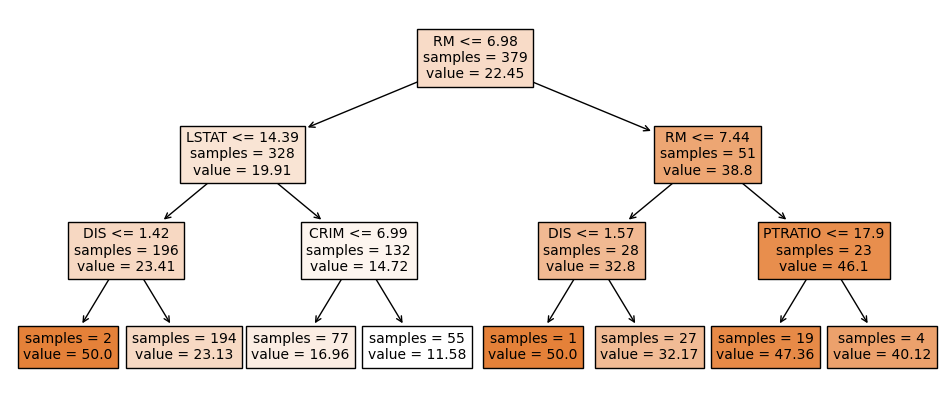

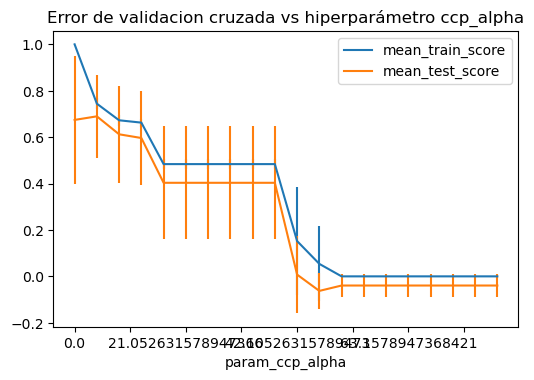

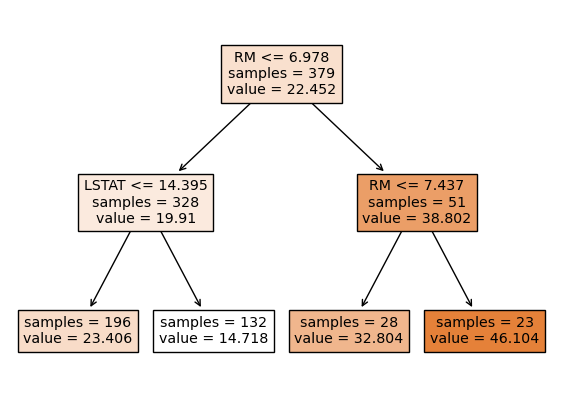

In [2]:

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

# Load the Boston housing dataset from the original source
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Create a DataFrame 
datos = pd.DataFrame(data, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
datos['MEDV'] = target # add target values as a column named 'MEDV'
datos.head(3)

datos.info()

# División de los datos en train y test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        random_state = 123
                                    )
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeRegressor(
            max_depth         = 3,
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

# Remove the 'class_names' parameter as it is not relevant for regression
plot = plot_tree(
            decision_tree = modelo,
            feature_names = datos.drop(columns = "MEDV").columns,
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

texto_modelo = export_text(
                    decision_tree = modelo,
                    feature_names = list(datos.drop(columns = "MEDV").columns)
               )
print(texto_modelo)

importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "MEDV").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

# Pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 80, 20)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible para luego aplicar el pruning
        estimator = DecisionTreeRegressor(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        cv         = 10,
        refit      = True,
        return_train_score = True
      )

grid.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_

# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

fig, ax = plt.subplots(figsize=(7, 5))
plot = plot_tree(
            decision_tree = modelo_final,
            feature_names = datos.drop(columns = "MEDV").columns,
            # Remove the 'class_names' parameter as it is not relevant for regression
            filled        = True,
            impurity      = False,
            ax            = ax
       )

# Error de test del modelo inicial
#-------------------------------------------------------------------------------
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

# Error de test del modelo final (tras aplicar pruning)
#-------------------------------------------------------------------------------
predicciones = modelo_final.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")